### Move to pytorch-pipeline directory

In [38]:
import os

os.getcwd()

In [39]:
# os.chdir("pytorch-pipeline")

## Prequisites

#### Following dependent packages needs to be installed before running the build script

1. kfp - Install kfp from source
2. docker - should be logged in using docker login
3. yq - install using snap - https://github.com/mikefarah/yq


#### ./build.sh takes two arguments

1. path to example - For ex: pytorch_pipeline/examples/bert
2. dockerhub username - For ex: shrinathsuresh


In [9]:
! pip install git+https://github.com/kubeflow/pipelines.git#subdirectory=sdk/python

  Cloning https://github.com/kubeflow/pipelines.git to /tmp/pip-req-build-o0t340ay
  Created wheel for kfp: filename=kfp-1.6.0rc0-py3-none-any.whl size=268377 sha256=2374b7a3d3ea6cd72822970ac4399c537270a64152a84bdef322544a431565cf
  Stored in directory: /tmp/pip-ephem-wheel-cache-hzbt8emw/wheels/30/e1/1f/9e3b96bb2a743990d4fb8728f3ebaddbff6a432299982d5ba2
Successfully built kfp


In [16]:
import kfp
kfp.__version__

'1.6.0-rc.0'

In [17]:
! ./build.sh pytorch_pipeline/examples/bert shrinathsuresh

++++ Building component images with tag=14-05-2021-16-13-48.856649
IMAGE TO BUILD: shrinathsuresh/pytorch_pipeline:14-05-2021-16-13-48.856649
Sending build context to Docker daemon   10.4MB
Step 1/9 : FROM pytorch/pytorch:latest
 ---> 5ffed6c83695
Step 2/9 : COPY requirements.txt requirements.txt
 ---> 74d2368d8b32
Step 3/9 : RUN apt-get update
 ---> Running in 7cd1c47f95d0
Get:1 http://archive.ubuntu.com/ubuntu bionic InRelease [242 kB]
Get:2 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:5 http://archive.ubuntu.com/ubuntu bionic/multiverse amd64 Packages [186 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [423 kB]
Get:7 http://archive.ubuntu.com/ubuntu bionic/universe amd64 Packages [11.3 MB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security/universe amd64 Packages 

## At the end of this step - pytorch_bert.yaml file will be generated

In [18]:
import kfp
import json
import os
from kfp import components
from kfp.components import load_component_from_file, load_component_from_url
from kfp import dsl
from kfp import compiler
from pathlib import Path

kfp.__version__

'1.6.0-rc.0'

## Update AUTH based on the environment

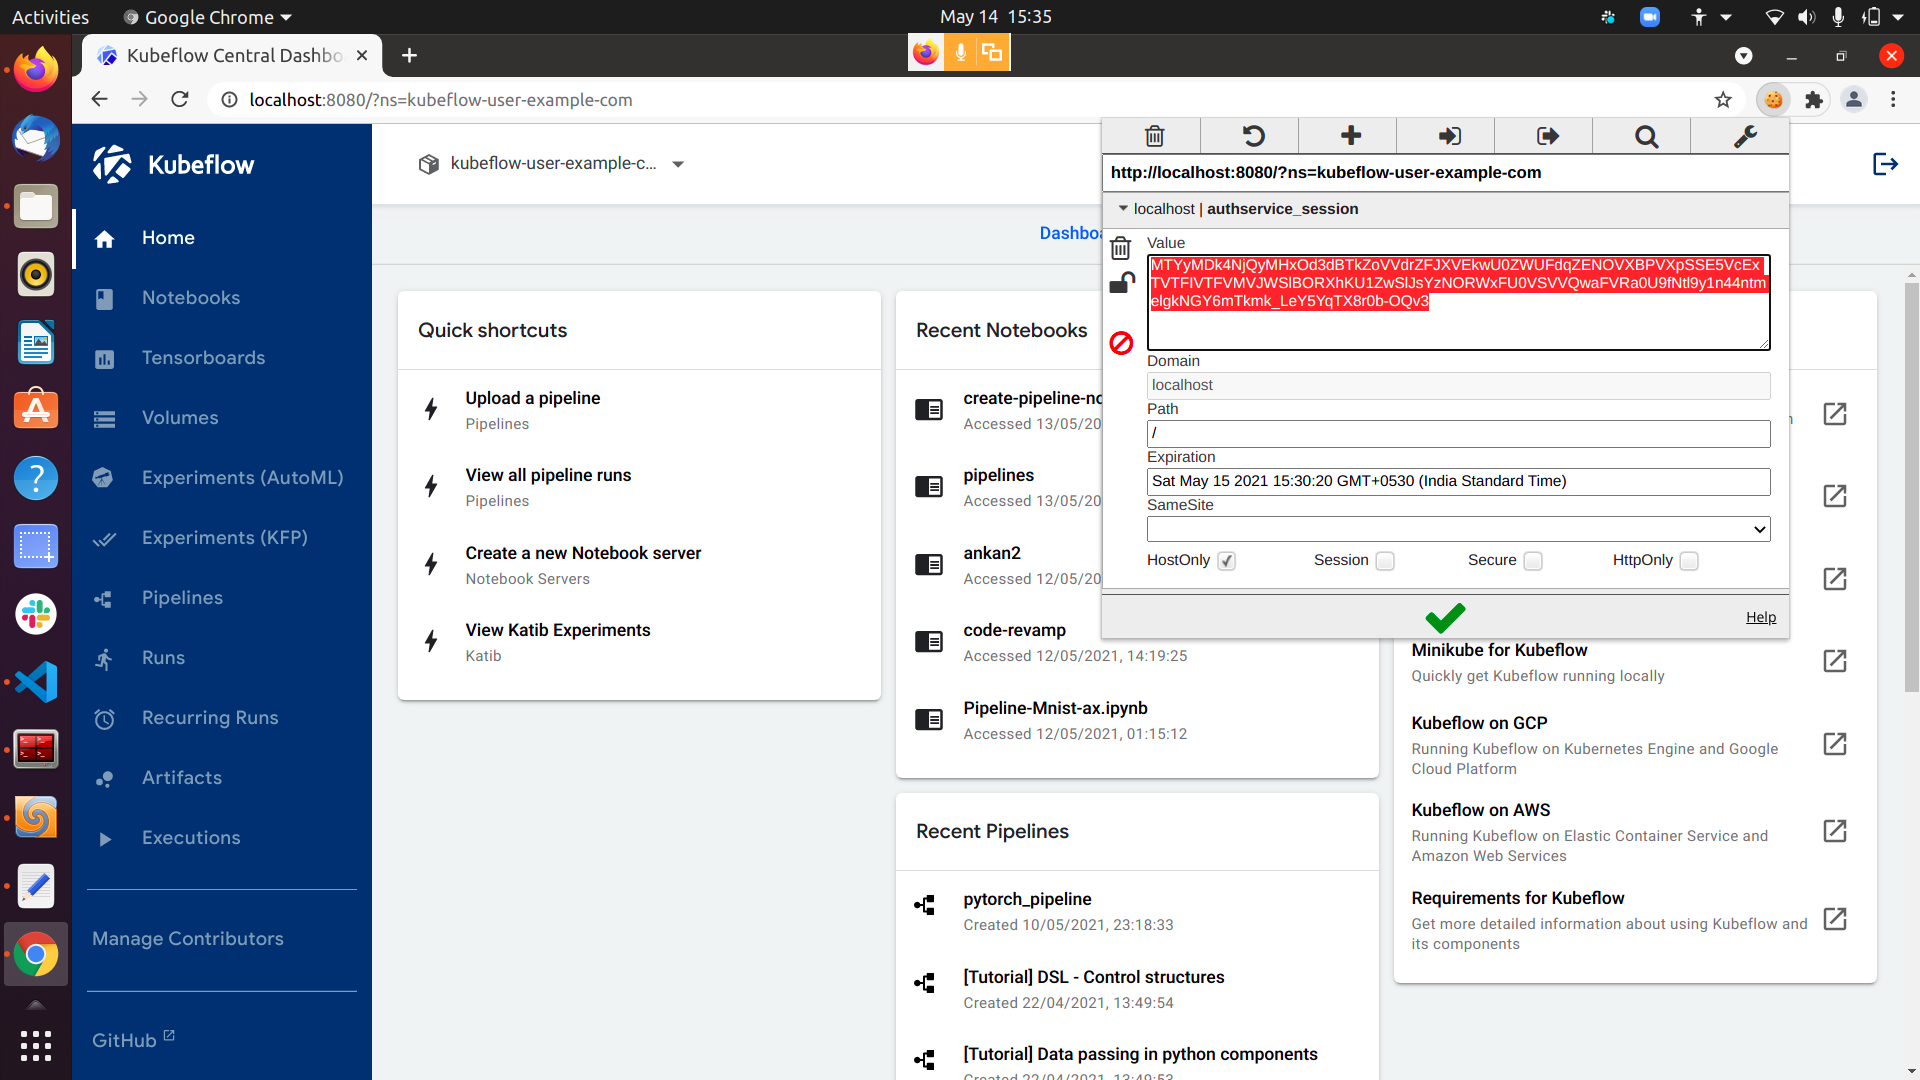

In [19]:
# KFP_URL='istio-ingressgateway.istio-system.svc.cluster.local'
KFP_URL='http://localhost:8080'
AUTH="authservice_session=MTYyMDk4NzkxN3xOd3dBTkVaTU5qWk5VRXRhVGt0RFV6UlZUVWhSVUZNMVVqVk5WRGMxVWpOQlVVTTJXRXd5VUVGWVJUSklUMGhMU1ZGTU4xRTJUVkU9fKafIMFRGe9R7dMBL3eDPSSruPZ1wC1fOUW2hnM3RFl8"
namespace="kubeflow-user-example-com"
client = kfp.Client(host=KFP_URL+"/pipeline", cookies=AUTH)
experiments = client.list_experiments(namespace=namespace)
my_experiment = experiments.experiments[0]
my_experiment

{'created_at': datetime.datetime(2021, 4, 22, 8, 44, 39, tzinfo=tzutc()),
 'description': None,
 'id': 'aac96a63-616e-4d88-9334-6ca8df2bb956',
 'name': 'Default',
 'resource_references': [{'key': {'id': 'kubeflow-user-example-com',
                                  'type': 'NAMESPACE'},
                          'name': None,
                          'relationship': 'OWNER'}],
 'storage_state': 'STORAGESTATE_AVAILABLE'}

## Click on Run Details for navigating to pipeline

In [20]:
run_name = 'pytorch-bert'
# Execute pipeline
run = client.run_pipeline(my_experiment.id, run_name, "pytorch_bert.yaml")

In [21]:
TEST = ! kubectl get isvc bertserve -n kubeflow-user-example-com -o jsonpath='{.status.url}'| cut -d "/" -f 3

HOST = TEST[0]
HOST

'bertserve.kubeflow-user-example-com.example.com'

In [22]:
MODEL_NAME="bert"

In [27]:
!curl -v -H "Host: $HOST" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:predict" -d @./pytorch_pipeline/examples/bert/sample.txt > ./bert_prediction_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/bert:predict HTTP/1.1
> Host: bertserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.71.1
> Accept: */*
> Cookie: authservice_session=MTYyMDk4NzkxN3xOd3dBTkVaTU5qWk5VRXRhVGt0RFV6UlZUVWhSVUZNMVVqVk5WRGMxVWpOQlVVTTJXRXd5VUVGWVJUSklUMGhMU1ZGTU4xRTJUVkU9fKafIMFRGe9R7dMBL3eDPSSruPZ1wC1fOUW2hnM3RFl8
> Content-Length: 84
> Content-Type: application/x-www-form-urlencoded
> 
} [84 bytes data]
* upload completely sent off: 84 out of 84 bytes
* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< content-length: 33
< content-type: application/json; charset=UTF-8
< date: Fri, 14 May 2021 11:00:58 GMT
< server: istio-envoy
< x-envoy-upstream-service-

In [28]:
! cat ./bert_prediction_output.json

{"predictions": ["\"Sci/Tech\""]}

In [31]:
!curl -v -H "Host: $HOST" -H "Cookie: $AUTH" "$KFP_URL/v1/models/$MODEL_NAME:explain" -d @./pytorch_pipeline/examples/bert/sample.txt  > bert_explaination_output.json

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0*   Trying 127.0.0.1:8080...
* Connected to localhost (127.0.0.1) port 8080 (#0)
> POST /v1/models/bert:explain HTTP/1.1
> Host: bertserve.kubeflow-user-example-com.example.com
> User-Agent: curl/7.71.1
> Accept: */*
> Cookie: authservice_session=MTYyMDk4NzkxN3xOd3dBTkVaTU5qWk5VRXRhVGt0RFV6UlZUVWhSVUZNMVVqVk5WRGMxVWpOQlVVTTJXRXd5VUVGWVJUSklUMGhMU1ZGTU4xRTJUVkU9fKafIMFRGe9R7dMBL3eDPSSruPZ1wC1fOUW2hnM3RFl8
> Content-Length: 84
> Content-Type: application/x-www-form-urlencoded
> 
} [84 bytes data]
* upload completely sent off: 84 out of 84 bytes
100    84    0     0  100    84      0      1  0:01:24  0:00:47  0:00:37     0* Mark bundle as not supporting multiuse
< HTTP/1.1 200 OK
< content-length: 319
< content-type: application/json; charset=UTF-8
< date: 

In [32]:
! cat bert_explaination_output.json

{"explanations": [{"words": ["[CLS]", "bloomberg", "has", "reported", "on", "the", "economy", "[SEP]"], "importances": [0.49803317807827413, -0.04228915625436579, -0.22691037181108395, 0.15573719339552444, 0.08677259891698845, 0.1791962203959244, 0.525546079847318, -0.5988261343532961], "delta": 0.12081549835977756}]}

In [33]:
import json
explanations_json = json.loads(open("./bert_explaination_output.json", "r").read())
explanations_json

{'explanations': [{'words': ['[CLS]',
    'bloomberg',
    'has',
    'reported',
    'on',
    'the',
    'economy',
    '[SEP]'],
   'importances': [0.49803317807827413,
    -0.04228915625436579,
    -0.22691037181108395,
    0.15573719339552444,
    0.08677259891698845,
    0.1791962203959244,
    0.525546079847318,
    -0.5988261343532961],
   'delta': 0.12081549835977756}]}

In [34]:
prediction_json = json.loads(open("./bert_prediction_output.json", "r").read())

In [35]:
import torch
attributions = explanations_json["explanations"][0]['importances']
tokens = explanations_json["explanations"][0]['words']
delta = explanations_json["explanations"][0]['delta']

attributions = torch.tensor(attributions)
pred_prob = 0.75
pred_class = prediction_json["predictions"][0]
true_class = "Business"
attr_class ="world"

In [36]:
from captum.attr import visualization
vis_data_records =[]
vis_data_records.append(visualization.VisualizationDataRecord(
                            attributions,
                            pred_prob,
                            pred_class,
                            true_class,
                            attr_class,
                            attributions.sum(),       
                            tokens,
                            delta))

In [37]:
visualization.visualize_text(vis_data_records)

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Business,"""Sci/Tech"" (0.75)",world,0.58,[CLS] bloomberg has reported on the economy [SEP]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
Business,"""Sci/Tech"" (0.75)",world,0.58,[CLS] bloomberg has reported on the economy [SEP]
